In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
# import from my drive 'riceClassification.csv'
data_df = pd.read_csv('/content/drive/My Drive/riceClassification.csv')

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# detect is gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)

cpu


In [ ]:
display(data_df.sample(5))

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
6775,6776,6983,166.325714,54.839632,0.944081,7189,94.292268,0.474099,370.739,0.638433,3.032947,1
13085,13086,7956,149.410989,68.830347,0.887567,8174,100.647374,0.567394,361.851,0.763563,2.170714,0
3260,3261,6478,154.434004,54.726243,0.935107,6668,90.818752,0.648903,348.927,0.668624,2.821937,1
2698,2699,5693,143.541405,51.548778,0.933291,5820,85.138433,0.535056,322.505,0.687825,2.784574,1
2833,2834,5861,145.490505,52.084103,0.933726,5960,86.385514,0.502659,326.347,0.691548,2.793376,1


In [ ]:
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB
None


In [ ]:
# drop id column
data_df.drop('id', axis=1, inplace=True)

In [ ]:
print(data_df.shape)

(18185, 11)


In [ ]:
# check for class imbalance
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [ ]:
# make a copy of the dataframe
original_df = data_df.copy()

In [ ]:
# normalize data
for column in data_df.columns:
  data_df[column] = data_df[column] / data_df[column].max()

In [ ]:
display(data_df.sample(5))

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
7075,0.650735,0.709219,0.802729,0.889746,0.617278,0.806681,0.686392,0.632529,0.891969,0.501258,0.0
5564,0.636141,0.863782,0.647331,0.973615,0.605469,0.797585,0.736648,0.694060,0.724214,0.757055,1.0
7013,0.674143,0.901456,0.656684,0.977061,0.639626,0.821062,0.608052,0.721514,0.710181,0.778822,1.0
3517,0.522919,0.763844,0.597643,0.967959,0.497093,0.723131,0.559204,0.617973,0.750935,0.725125,1.0
2170,0.640842,0.833720,0.674271,0.963246,0.611464,0.800526,0.614701,0.681964,0.755676,0.701513,1.0


In [ ]:
# converto to numpy array
X = np.array(data_df.iloc[:, :-1]) # all rows, all columns but the last one

In [ ]:
# for Y only take last column Class
Y = np.array(data_df.iloc[:, -1])

- Split dataset into train, test and validation sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=69)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=69)

In [ ]:
print(X_train.shape, X_test.shape, X_val.shape)

(12729, 10) (2728, 10) (2728, 10)


# pyTorch Dataset

In [ ]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


In [ ]:
training_data = dataset(X_train, y_train)
testing_data = dataset(X_test, y_test)
validation_data = dataset(X_val, y_val)

# pyTorch DataLoader

In [ ]:
batch = 32

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=batch, shuffle=True)

In [ ]:
validation_dataloader = DataLoader(validation_data, batch_size=batch, shuffle=True)

In [ ]:
testing_dataloader = DataLoader(testing_data, batch_size=batch, shuffle=True)

In [ ]:
for x, y in train_dataloader:
  print(x)
  print('-----------------------')
  print(y)
  break
# prints eigth tensor rows and their corresponding targets, as defined in batch_size

tensor([[0.5203, 0.7938, 0.5707, 0.9786, 0.4949, 0.7213, 0.6339, 0.6374, 0.7023,
         0.7891],
        [0.6164, 0.8315, 0.6492, 0.9683, 0.5869, 0.7851, 0.6895, 0.6733, 0.7456,
         0.7267],
        [0.6859, 0.8838, 0.6794, 0.9703, 0.6509, 0.8282, 0.8385, 0.7142, 0.7374,
         0.7381],
        [0.6679, 0.9171, 0.6372, 0.9824, 0.6376, 0.8172, 0.5816, 0.7205, 0.7056,
         0.8166],
        [0.9018, 0.9005, 0.8750, 0.9300, 0.8635, 0.9496, 0.7212, 0.7715, 0.8309,
         0.5839],
        [0.8279, 0.8354, 0.8695, 0.9136, 0.7901, 0.9099, 0.7937, 0.7311, 0.8494,
         0.5451],
        [0.5610, 0.7818, 0.6300, 0.9638, 0.5326, 0.7490, 0.5601, 0.6364, 0.7597,
         0.7040],
        [0.8852, 0.8673, 0.8883, 0.9176, 0.8408, 0.9409, 0.6845, 0.7517, 0.8591,
         0.5540],
        [0.5570, 0.7844, 0.6313, 0.9640, 0.5414, 0.7463, 0.8365, 0.6708, 0.6789,
         0.7049],
        [0.8663, 0.8664, 0.8683, 0.9229, 0.8200, 0.9308, 0.8582, 0.7413, 0.8645,
         0.5661],
        [0

# Building the model

In [ ]:
HIDDEN_NEURONS = 12
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__() # use constructor from parent class

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1) # one output since its a class problem
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

In [ ]:
model = MyModel().to(device)

In [ ]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
            Linear-2                    [-1, 1]              13
           Sigmoid-3                    [-1, 1]               0
Total params: 145
Trainable params: 145
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- DEfine loss function

In [ ]:
criterion = nn.BCELoss()

- Choose optimizer

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)

# Training Loop

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

In [ ]:
epochs = 20
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0
  for data in train_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1) # squeeze to match shapes
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    # batch accuracy
    acc = (prediction.round() == labels).sum().item() # make a break here to see
    total_acc_train += acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # validation
  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item()
      acc = (prediction.round() == labels).sum().item()
      total_acc_val += acc

  total_loss_train_plot.append(total_loss_train / len(train_dataloader))
  total_loss_validation_plot.append(total_loss_val / len(validation_dataloader))
  total_acc_train_plot.append(total_acc_train / len(train_dataloader.dataset))
  total_acc_validation_plot.append(total_acc_val / len(validation_dataloader.dataset))
  # print train accuracy
  print(f'Epoch No.{epoch+1} Train Loss: {total_loss_train / len(train_dataloader)} Train Acc: {total_acc_train / len(train_dataloader.dataset)}')

Epoch No.1 Train Loss: 0.5695495902743172 Train Acc: 0.9138188388718674
Epoch No.2 Train Loss: 0.2539614762305914 Train Acc: 0.9776101814753712
Epoch No.3 Train Loss: 0.12143853347954439 Train Acc: 0.9826380705475686
Epoch No.4 Train Loss: 0.08131626493124357 Train Acc: 0.9844449681828895
Epoch No.5 Train Loss: 0.06467996383712969 Train Acc: 0.9846806504831487
Epoch No.6 Train Loss: 0.05632336841821296 Train Acc: 0.9853091366171733
Epoch No.7 Train Loss: 0.051726581649293175 Train Acc: 0.9854662581506796
Epoch No.8 Train Loss: 0.04891423672559348 Train Acc: 0.9853876973839265
Epoch No.9 Train Loss: 0.046391235974537745 Train Acc: 0.9853091366171733
Epoch No.10 Train Loss: 0.04460506185060882 Train Acc: 0.9864875481184696
Epoch No.11 Train Loss: 0.044241619870843525 Train Acc: 0.9853876973839265
Epoch No.12 Train Loss: 0.04334578620288615 Train Acc: 0.985859061984445
Epoch No.13 Train Loss: 0.04329990717668985 Train Acc: 0.9853091366171733
Epoch No.14 Train Loss: 0.04286312139341514 Tra

# Testing

In [ ]:
with torch.no_grad():
  total_acc_test = 0
  total_loss_test = 0
  for data in testing_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels).item()
    total_loss_test += batch
    acc = (prediction.round() == labels).sum().item()
    total_acc_test += acc
print(f'Accuracy: {total_acc_test / len(testing_dataloader.dataset)}')

Accuracy: 0.9879032258064516


# Ploting results.

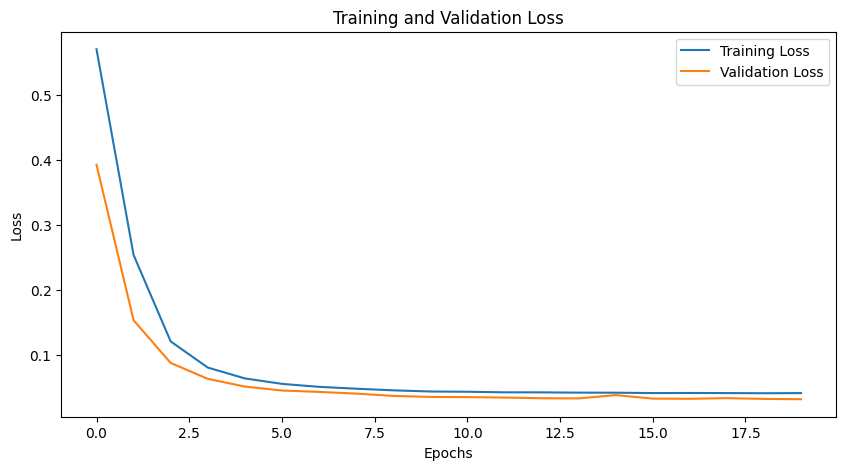

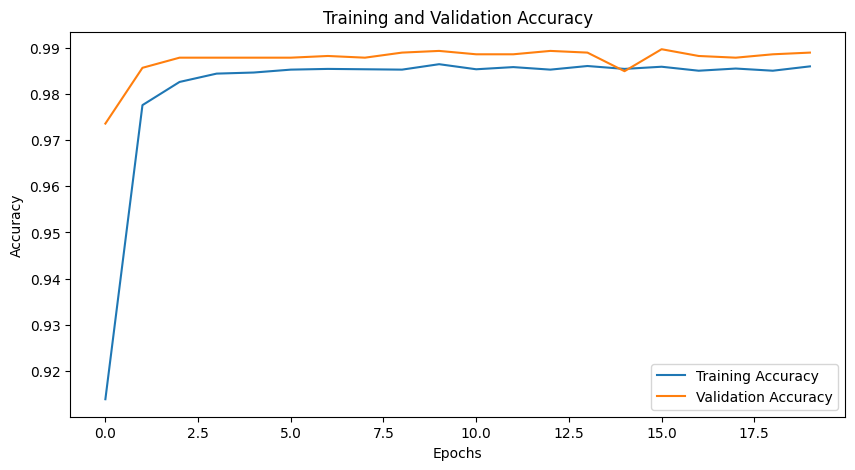

In [ ]:
# prompt: can you plot training loss and validation loss over epochs?

# Ploting results.
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(total_loss_train_plot, label="Training Loss")
plt.plot(total_loss_validation_plot, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(total_acc_train_plot, label="Training Accuracy")
plt.plot(total_acc_validation_plot, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
